# Crime data in Hampshire on March 2019

This data includes a few things including the type of crime, location where it took place (latitude, longitude, LSOA code and name), last outcome category just to mention some of them.

### Challenge: Predict if the accused received any form of punishment.

This information is part of last outcome of the case, under the name of `Last outcome category` in the dataset. The following outcomes are considered as punishment:

- Offender given a caution
- Offender given community sentence
- Offender fined
- Offender given conditional discharge
- Offender sent to prison
- Offender given suspended prison sentence
- Offender ordered to pay compensation 
- Offender deprived of property
- Offender given a drugs possession warning


In this second section, we analyze every feature and its relation with the outcome of the case

In [1]:
from matplotlib import pyplot as plt
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
import json

In [2]:
df = pd.read_csv('../data/2019-03-hampshire-street.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13757 entries, 0 to 13756
Data columns (total 12 columns):
Crime ID                 12836 non-null object
Month                    13757 non-null object
Reported by              13757 non-null object
Falls within             13757 non-null object
Longitude                13757 non-null float64
Latitude                 13757 non-null float64
Location                 13757 non-null object
LSOA code                13757 non-null object
LSOA name                13757 non-null object
Crime type               13757 non-null object
Last outcome category    12836 non-null object
Context                  0 non-null float64
dtypes: float64(3), object(9)
memory usage: 1.3+ MB


1. Drop the column `Context` because it's completely empty.
2. Drop the rows with nan values (check that Crime ID, Last outcome have less information than the rest of columns)

In [4]:
df.drop(columns='Context', inplace=True)

In [5]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12836 entries, 0 to 13756
Data columns (total 11 columns):
Crime ID                 12836 non-null object
Month                    12836 non-null object
Reported by              12836 non-null object
Falls within             12836 non-null object
Longitude                12836 non-null float64
Latitude                 12836 non-null float64
Location                 12836 non-null object
LSOA code                12836 non-null object
LSOA name                12836 non-null object
Crime type               12836 non-null object
Last outcome category    12836 non-null object
dtypes: float64(2), object(9)
memory usage: 1.2+ MB


Look at the first five rows:

In [6]:
df.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category
0,1edc0409a584e44e41914d2997bdbdd43614ca889b5199...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-0.650636,50.793666,On or near Ferring Gardens,E01031421,Arun 015E,Violence and sexual offences,Status update unavailable
1,4a7fbc063a0515d44ca605dc05cedcc487032aef6db481...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-0.650636,50.793666,On or near Ferring Gardens,E01031421,Arun 015E,Violence and sexual offences,Status update unavailable
2,4b7781de32fc30b4a5f78720f47aa5b89c216967039eee...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-1.144842,51.350275,On or near Denmead Road,E01022553,Basingstoke and Deane 001A,Burglary,Investigation complete; no suspect identified
3,8dfe557629cfd86e61d8b9fd5d4381b17a5fd63464092b...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-1.145593,51.354669,On or near Silverdale Road,E01022553,Basingstoke and Deane 001A,Violence and sexual offences,Unable to prosecute suspect
4,f67410fb5f97ede46d0a6b1500ebcb4fb8085366df48de...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-1.155230,51.353821,On or near Huntsmoor Road,E01022554,Basingstoke and Deane 001B,Criminal damage and arson,Investigation complete; no suspect identified


All of those crimes happened on March. Therefore, the column `Month` doesn't offer additional information. Latitude and Longitude are interesting data for mapping the crimes, as we did in the first section using the polygonal information associated with LSOA codes. Let's use `Location`, `LSOA code` or `LSOA name` (not both, because they are dependent and that's an undesirable condition on predictive modeling) and `Crime type`. As a binary classification problem, the question is if the crime received any kind of punishment, not the nature of the outcome. Also, we have a list of outcomes that are considered as punishment. 

The next step is defining the label `punishment`. We looks for the keywords of the list on the column `Last outcome category` to determine if the outome is a punishment, it means, 1 or not (0).

Firstly, we inspect the possible outcomes on the data:

In [7]:
outcome_list = df['Last outcome category'].unique()
outcome_list

array(['Status update unavailable',
       'Investigation complete; no suspect identified',
       'Unable to prosecute suspect', 'Awaiting court outcome',
       'Local resolution', 'Court result unavailable',
       'Formal action is not in the public interest',
       'Offender given a caution',
       'Action to be taken by another organisation',
       'Court case unable to proceed',
       'Offender given community sentence',
       'Offender ordered to pay compensation',
       'Offender given suspended prison sentence',
       'Offender given conditional discharge', 'Offender fined',
       'Offender sent to prison',
       'Suspect charged as part of another case',
       'Defendant found not guilty', 'Offender deprived of property',
       'Offender given a drugs possession warning',
       'Offender otherwise dealt with', 'Defendant sent to Crown Court'],
      dtype=object)

Two alternatives to label the outomes:

1. Determine if every outcome is in a pre-defined list of punishments. This is the easiest option, but what if the outcome doesn't match perfectly with the pre-defined outcomes? An extra (or lack of) space or special character is all you need to ruin the detection. It motivates the use of another choice.
2. Create a dictionary of punishments words and determine if some expressions in the outcome words belong to the dictionary.

Importing **nltk** tools as the default list of stopwords in English language and the tokenization of words into a sentences:

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

Inspecting the list of outcomes that we must consider as punishments:

- The word **offender** is in all the outcomes that classify as punishments.
- The same word, **offender** is additionally in the outcome **Offender otherwise dealt with** that is not a punishment.

Under that scenario, the **punishment list** is defined using the below conditions:

In [9]:
punishments = []
for outcome in outcome_list:
    tokens = word_tokenize(outcome)
    if 'Offender' in tokens and 'otherwise' not in tokens:
        punishments.append(outcome)

Displaying the list:

In [10]:
punishments

['Offender given a caution',
 'Offender given community sentence',
 'Offender ordered to pay compensation',
 'Offender given suspended prison sentence',
 'Offender given conditional discharge',
 'Offender fined',
 'Offender sent to prison',
 'Offender deprived of property',
 'Offender given a drugs possession warning']

The punishment list is used to create the set of **punishment keywords**, applying stemming and deletion of stop words.

In [11]:
stopwords = set(stopwords.words('english'))

In [12]:
keywords = [word.lower() for punishment in punishments for word in word_tokenize(punishment) if word not in stopwords]

Displaying the punishment keyword:

In [13]:
punish_keywords = set(keywords)
punish_keywords

{'caution',
 'community',
 'compensation',
 'conditional',
 'deprived',
 'discharge',
 'drugs',
 'fined',
 'given',
 'offender',
 'ordered',
 'pay',
 'possession',
 'prison',
 'property',
 'sent',
 'sentence',
 'suspended',
 'warning'}

In [14]:
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
stemmer = nltk.stem.porter.PorterStemmer()

In [15]:
[stemmer.stem(word.translate(remove_punct_dict)) for word in punish_keywords]

['discharg',
 'pay',
 'compens',
 'fine',
 'possess',
 'given',
 'offend',
 'warn',
 'suspend',
 'properti',
 'caution',
 'prison',
 'order',
 'sent',
 'condit',
 'commun',
 'drug',
 'sentenc',
 'depriv']

In [16]:
def classify_punishment(outcome):
    word_list = [word.lower() for word in word_tokenize(outcome)]
    outcome_set = set([stemmer.stem(word.translate(remove_punct_dict)) for word in word_list])
    coincidence = len(outcome_set.intersection(punish_keywords))
    if coincidence >= 2:
        return 1
    else:
        return 0

In [17]:
df['label'] = df['Last outcome category'].apply(classify_punishment)

In [18]:
df.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,label
0,1edc0409a584e44e41914d2997bdbdd43614ca889b5199...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-0.650636,50.793666,On or near Ferring Gardens,E01031421,Arun 015E,Violence and sexual offences,Status update unavailable,0
1,4a7fbc063a0515d44ca605dc05cedcc487032aef6db481...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-0.650636,50.793666,On or near Ferring Gardens,E01031421,Arun 015E,Violence and sexual offences,Status update unavailable,0
2,4b7781de32fc30b4a5f78720f47aa5b89c216967039eee...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-1.144842,51.350275,On or near Denmead Road,E01022553,Basingstoke and Deane 001A,Burglary,Investigation complete; no suspect identified,0
3,8dfe557629cfd86e61d8b9fd5d4381b17a5fd63464092b...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-1.145593,51.354669,On or near Silverdale Road,E01022553,Basingstoke and Deane 001A,Violence and sexual offences,Unable to prosecute suspect,0
4,f67410fb5f97ede46d0a6b1500ebcb4fb8085366df48de...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-1.155230,51.353821,On or near Huntsmoor Road,E01022554,Basingstoke and Deane 001B,Criminal damage and arson,Investigation complete; no suspect identified,0


In [19]:
df[df.label == 1].head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,label
78,14fec825996b563291dc971e8c4adbf026ea5dfadb82e7...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-1.335400,51.346718,On or near Pound Lane,E01022489,Basingstoke and Deane 003B,Violence and sexual offences,Offender given a caution,1
148,2acb8489189c01d7ee48275de61349eba6914a9b41ba46...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-1.049255,51.301467,On or near Rowner Crescent,E01022496,Basingstoke and Deane 006B,Violence and sexual offences,Offender given a caution,1
228,7d381892579a89a8d92d412eca573a5774ec4fca5bbc7f...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-1.098325,51.281066,On or near Tintern Close,E01022543,Basingstoke and Deane 007F,Violence and sexual offences,Offender given a caution,1
338,f558e324e68a6cb3dbd9190ba395785c51b904ddec5cea...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-1.078904,51.276410,On or near Coleman Close,E01022523,Basingstoke and Deane 008D,Violence and sexual offences,Offender given a caution,1
487,5b196880152653518c2dc40359ebfb9cb02543a987232c...,2019-03,Hampshire Constabulary,Hampshire Constabulary,-1.073094,51.256644,On or near Renoir Close,E01022506,Basingstoke and Deane 011C,Violence and sexual offences,Offender given a caution,1


In [20]:
dist_punishment = df.groupby('label').count().reset_index().rename(columns={'Crime ID': 'number_crimes'}).loc[:, ['number_crimes', 'label']]
dist_punishment 

,number_crimes,label
0,12628,0
1,208,1


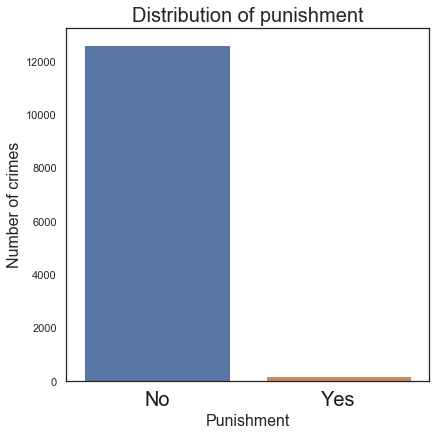

In [21]:
sns.set(style='white')

_ = plt.figure(figsize=(6.5, 6.5))
_ = sns.barplot(x='label', y='number_crimes', data=dist_punishment)
_ = plt.title('Distribution of punishment', size=20)
_ = plt.xticks((0, 1), ('No', 'Yes'), color='k', size=20)
_ = plt.xlabel('Punishment', size=16)
_ = plt.ylabel('Number of crimes', size=16)

#### Types of crimes

In [22]:
dist_crimes = df.groupby('Crime type').count().reset_index().rename(columns={'Crime ID': 'number_crimes'}).loc[:, ['Crime type', 'number_crimes']]
dist_crimes.sort_values(by=['number_crimes'], inplace=True)

In [23]:
dist_crimes

,Crime type,number_crimes
10,Theft from the person,85
8,Robbery,120
6,Possession of weapons,170
4,Other crime,237
0,Bicycle theft,248
3,Drugs,352
11,Vehicle crime,896
1,Burglary,916
5,Other theft,1020
9,Shoplifting,1035


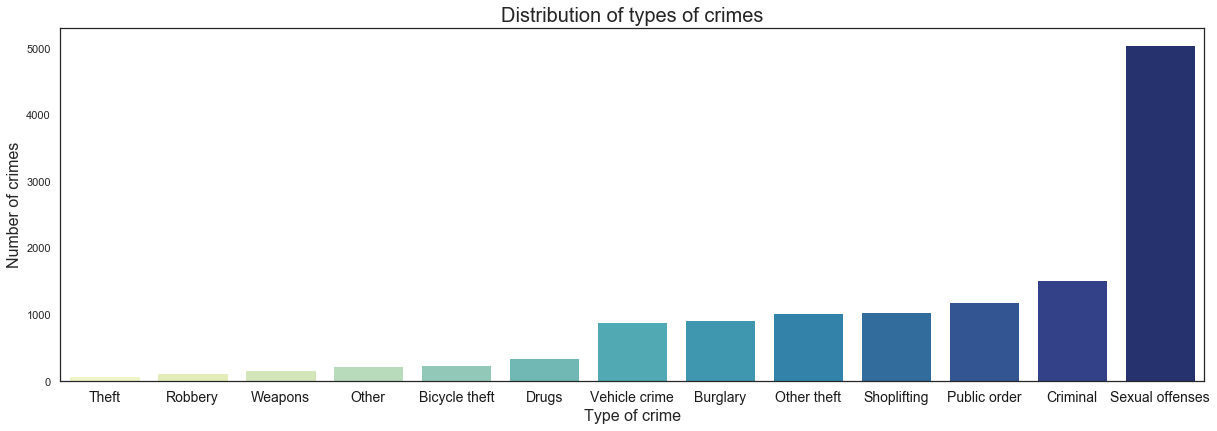

In [24]:
sns.set(style='white')

_ = plt.figure(figsize=(20.5, 6.5))
_ = sns.barplot(x='Crime type', y='number_crimes', data=dist_crimes, palette='YlGnBu')
_ = plt.title('Distribution of types of crimes', size=20)
_ = plt.xticks((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), 
               ('Theft', 
                'Robbery', 
                'Weapons', 
                'Other', 
                'Bicycle theft', 
                'Drugs', 
                'Vehicle crime', 
                'Burglary', 
                'Other theft', 
                'Shoplifting', 
                'Public order',
                'Criminal', 
                'Sexual offenses'), color='k', size=14)
_ = plt.xlabel('Type of crime', size=16)
_ = plt.ylabel('Number of crimes', size=16)

In [25]:
df_modeling = df.loc[:, ['Location', 'LSOA name', 'Crime type', 'label']]

In [26]:
df_modeling.head()

,Location,LSOA name,Crime type,label
0,On or near Ferring Gardens,Arun 015E,Violence and sexual offences,0
1,On or near Ferring Gardens,Arun 015E,Violence and sexual offences,0
2,On or near Denmead Road,Basingstoke and Deane 001A,Burglary,0
3,On or near Silverdale Road,Basingstoke and Deane 001A,Violence and sexual offences,0
4,On or near Huntsmoor Road,Basingstoke and Deane 001B,Criminal damage and arson,0


In [27]:
location = pd.get_dummies(df_modeling['Location'], prefix='Location')
lsoa = pd.get_dummies(df_modeling['LSOA name'], prefix='LSOA name')
crime = pd.get_dummies(df_modeling['Crime type'], prefix='Crime type')

In [28]:
data = location.join(lsoa)
data = data.join(crime)

In [29]:
data.head()

,Location_On or near A2030,Location_On or near A27,Location_On or near A272,Location_On or near A30,Location_On or near A3020,Location_On or near A3023,Location_On or near A303,Location_On or near A3057,Location_On or near A3093,Location_On or near A31,...,Crime type_Drugs,Crime type_Other crime,Crime type_Other theft,Crime type_Possession of weapons,Crime type_Public order,Crime type_Robbery,Crime type_Shoplifting,Crime type_Theft from the person,Crime type_Vehicle crime,Crime type_Violence and sexual offences
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
data.columns

Index(['Location_On or near A2030', 'Location_On or near A27',
       'Location_On or near A272', 'Location_On or near A30',
       'Location_On or near A3020', 'Location_On or near A3023',
       'Location_On or near A303', 'Location_On or near A3057',
       'Location_On or near A3093', 'Location_On or near A31',
       ...
       'Crime type_Drugs', 'Crime type_Other crime', 'Crime type_Other theft',
       'Crime type_Possession of weapons', 'Crime type_Public order',
       'Crime type_Robbery', 'Crime type_Shoplifting',
       'Crime type_Theft from the person', 'Crime type_Vehicle crime',
       'Crime type_Violence and sexual offences'],
      dtype='object', length=5756)

### Over sampling using SMOTE

As we checked before, 98% of data belongs to the same category. In that unbalanced scenario, we use [SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html) for oversampling the category with less information.

In [31]:
import sys

!{sys.executable} -m pip install imbalanced-learn

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [37]:
y = df_modeling.label
X = data

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [39]:
from imblearn.over_sampling import RandomOverSampler # doctest: +NORMALIZE_WHITESPACE

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Using TensorFlow backend.


Resampled dataset shape Counter({0: 12628, 1: 12628})


In [40]:
from imblearn.over_sampling import BorderlineSMOTE# doctest: +NORMALIZE_WHITESPACE

sm = BorderlineSMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 12628, 1: 12628})


In [41]:
columns = X_train.columns

In [42]:
os_data_X = pd.DataFrame(data=X_res, columns=columns)
os_data_y= pd.DataFrame(data=y_res)

In [43]:
os_data_X.head()

,Location_On or near A2030,Location_On or near A27,Location_On or near A272,Location_On or near A30,Location_On or near A3020,Location_On or near A3023,Location_On or near A303,Location_On or near A3057,Location_On or near A3093,Location_On or near A31,...,Crime type_Drugs,Crime type_Other crime,Crime type_Other theft,Crime type_Possession of weapons,Crime type_Public order,Crime type_Robbery,Crime type_Shoplifting,Crime type_Theft from the person,Crime type_Vehicle crime,Crime type_Violence and sexual offences
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
#print(os_data_y)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(os_data_X, os_data_y, test_size=0.3, random_state=0)

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [47]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.98


In [49]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[3747   50]
 [  87 3693]]


In [50]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3797
           1       0.99      0.98      0.98      3780

    accuracy                           0.98      7577
   macro avg       0.98      0.98      0.98      7577
weighted avg       0.98      0.98      0.98      7577



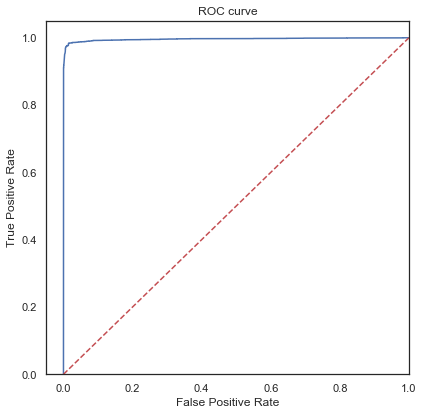

In [52]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

_ = plt.figure(figsize=(6.5, 6.5))
_ = plt.plot(fpr, tpr)
_ = plt.plot([0, 1], [0, 1],'r--')
_ = plt.xlim([-0.05, 1.0])
_ = plt.ylim([0.0, 1.05])
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC curve')
#plt.savefig('Log_ROC')
_ = plt.show()